## Teste 1 sem conectar com mapa (Fictício)

In [ ]:
import math
from collections import defaultdict
import pandas as pd
import heapq

In [ ]:
# 1) Definição do grafo viário
# Coordenadas (x, y) em km (projeção fictícia) para estimar heurística por distância em linha reta
coords = {
    "Base_Norte": (2, 18),
    "Base_Sul": (4, 2),
    "Bairro_A": (5, 16),
    "Bairro_B": (9, 14),
    "Bairro_C": (12, 12),
    "Bairro_D": (14, 9),
    "Bairro_E": (10, 7),
    "Bairro_F": (7, 5),
    "Bairro_G": (3, 9),
    "Bairro_H": (6, 11),
    "Bairro_I": (11, 4),
    "Paciente": (8, 10),  # Local do wearable que disparou alerta
    "Hospital_Geral": (15, 5),
    "Cardio_Center": (16, 11),
}

In [ ]:
# Arestas com custos (minutos) - tempo estimado de deslocamento por via (considera trânsito médio)
G = defaultdict(dict)

def add_edge(a, b, cost):
    G[a][b] = cost
    G[b][a] = cost

add_edge("Base_Norte", "Bairro_A", 6)
add_edge("Bairro_A", "Bairro_B", 5)
add_edge("Bairro_B", "Bairro_C", 6)
add_edge("Bairro_C", "Cardio_Center", 7)

add_edge("Base_Norte", "Bairro_H", 7)
add_edge("Bairro_H", "Bairro_B", 6)
add_edge("Bairro_H", "Paciente", 4)

add_edge("Paciente", "Bairro_B", 3)
add_edge("Paciente", "Bairro_D", 8)
add_edge("Paciente", "Bairro_E", 7)
add_edge("Paciente", "Bairro_F", 6)

add_edge("Bairro_D", "Cardio_Center", 4)
add_edge("Bairro_D", "Hospital_Geral", 6)

add_edge("Bairro_E", "Bairro_D", 4)
add_edge("Bairro_E", "Bairro_I", 5)
add_edge("Bairro_I", "Hospital_Geral", 3)

add_edge("Bairro_F", "Bairro_E", 3)
add_edge("Bairro_F", "Base_Sul", 5)

add_edge("Base_Sul", "Bairro_I", 6)
add_edge("Base_Sul", "Bairro_G", 7)
add_edge("Bairro_G", "Bairro_H", 6)



In [ ]:
# 2) Heurística: distância em linha reta (minutos)
# velocidade média suposta (km/h) -> km/min
vel_kmh = 30  # média urbana com trânsito (ajustável)
vel_km_min = vel_kmh / 60.0

def straight_line_time(u, v):
    (x1, y1), (x2, y2) = coords[u], coords[v]
    dist_km = math.hypot(x1 - x2, y1 - y2)
    return dist_km / vel_km_min

In [ ]:
# 3) Algoritmos de Busca
def greedy_best_first_search(start, goal, h):
    """Retorna (path, cost, expanded) usando Busca Gulosa (Best-First com f(n)=h(n))."""
    frontier = []
    heapq.heappush(frontier, (h(start, goal), start))
    came_from = {start: None}
    expanded = 0
    visited = set()

    while frontier:
        _, current = heapq.heappop(frontier)
        if current in visited:
            continue
        visited.add(current)
        expanded += 1

        if current == goal:
            break

        for neighbor, cost in G[current].items():
            if neighbor not in visited:
                if neighbor not in came_from:
                    came_from[neighbor] = (current, cost)
                heapq.heappush(frontier, (h(neighbor, goal), neighbor))

    if goal not in came_from and goal != start:
        return [], math.inf, expanded

    path = [goal]
    total = 0
    node = goal
    while node != start:
        prev, c = came_from[node]
        total += c
        path.append(prev)
        node = prev
    path.reverse()
    return path, total, expanded

def a_star_search(start, goal, h):
    """Retorna (path, cost, expanded) usando A* (f(n) = g(n) + h(n))."""
    frontier = []
    heapq.heappush(frontier, (h(start, goal), 0, start))
    came_from = {start: None}
    g = {start: 0}
    expanded = 0
    closed = set()

    while frontier:
        f_val, g_val, current = heapq.heappop(frontier)
        if current in closed:
            continue
        closed.add(current)
        expanded += 1

        if current == goal:
            break

        for neighbor, cost in G[current].items():
            tentative_g = g_val + cost
            if neighbor not in g or tentative_g < g[neighbor]:
                g[neighbor] = tentative_g
                came_from[neighbor] = (current, cost)
                heapq.heappush(frontier, (tentative_g + h(neighbor, goal), tentative_g, neighbor))

    if goal not in came_from and goal != start:
        return [], math.inf, expanded

    path = [goal]
    total = 0
    node = goal
    while node != start:
        prev, c = came_from[node]
        total += c
        path.append(prev)
        node = prev
    path.reverse()
    return path, total, expanded

In [ ]:
# 4) Cenário: escolher base e hospital, e calcular rotas base->paciente->hospital

bases = ["Base_Norte", "Base_Sul"]
hospitais = ["Cardio_Center", "Hospital_Geral"]
paciente = "Paciente"

def run_strategy(search_fn, name):
    records = []
    for base in bases:
        for hos in hospitais:
            # perna 1: base -> paciente
            p1_path, p1_cost, p1_exp = search_fn(base, paciente, straight_line_time)
            # perna 2: paciente -> hospital
            p2_path, p2_cost, p2_exp = search_fn(paciente, hos, straight_line_time)

            path = (p1_path[:-1] + p2_path) if p1_path and p2_path else []
            total_cost = p1_cost + p2_cost
            total_expanded = p1_exp + p2_exp

            records.append({
                "Algoritmo": name,
                "Base": base,
                "Hospital": hos,
                "Caminho": " -> ".join(path) if path else "(sem rota)",
                "Tempo_total_estimado(min)": total_cost,
                "Nos_expandidos": total_expanded
            })
    df = pd.DataFrame.from_records(records)
    return df

def best_options(df):
    idx = df["Tempo_total_estimado(min)"].idxmin()
    return df.loc[[idx]]

def main():
    df_greedy = run_strategy(greedy_best_first_search, "Busca Gulosa")
    df_astar = run_strategy(a_star_search, "A*")

    best_greedy = best_options(df_greedy)
    best_astar = best_options(df_astar)

    df_all = pd.concat([df_greedy, df_astar], ignore_index=True)
    df_compare_best = pd.concat([best_greedy, best_astar], ignore_index=True)

    # Salvar CSVs
    df_all.to_csv("resultado_buscas_wearables_todas_combinacoes.csv", index=False, encoding="utf-8")
    df_compare_best.to_csv("resultado_buscas_wearables_melhores.csv", index=False, encoding="utf-8")

     # Prints resumidos
    print("TODAS AS COMBINAÇÕES")
    print(df_all.to_string(index=False))
    print("MELHORES POR ALGORITMO")
    print(df_compare_best.to_string(index=False))
    print("\nArquivos salvos:")
    print(" - resultado_buscas_wearables_todas_combinacoes.csv")
    print(" - resultado_buscas_wearables_melhores.csv")

if __name__ == "__main__":
    main()

TODAS AS COMBINAÇÕES
   Algoritmo       Base       Hospital                                                          Caminho  Tempo_total_estimado(min)  Nos_expandidos
Busca Gulosa Base_Norte  Cardio_Center  Base_Norte -> Bairro_H -> Paciente -> Bairro_D -> Cardio_Center                         23               6
Busca Gulosa Base_Norte Hospital_Geral Base_Norte -> Bairro_H -> Paciente -> Bairro_D -> Hospital_Geral                         25               6
Busca Gulosa   Base_Sul  Cardio_Center    Base_Sul -> Bairro_F -> Paciente -> Bairro_D -> Cardio_Center                         23               6
Busca Gulosa   Base_Sul Hospital_Geral   Base_Sul -> Bairro_F -> Paciente -> Bairro_D -> Hospital_Geral                         25               6
          A* Base_Norte  Cardio_Center  Base_Norte -> Bairro_H -> Paciente -> Bairro_D -> Cardio_Center                         23               6
          A* Base_Norte Hospital_Geral Base_Norte -> Bairro_H -> Paciente -> Bairro_D -> Hospital

# Conectando com API de mapa (Dados Reais)


In [ ]:
import math
import heapq
import pandas as pd
from collections import defaultdict

In [ ]:
def haversine(coord1, coord2):
    R = 6371  # raio da Terra em km
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)

    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2*math.atan2(math.sqrt(a), math.sqrt(1-a))
    return R * c  # distância em km

In [ ]:
vel_kmh = 40  # média urbana
def heuristic(u, v, coords):
    dist_km = haversine(coords[u], coords[v])
    return dist_km / vel_kmh * 60  # tempo em minutos

In [ ]:
def greedy_best_first_search(start, goal, coords, G):
    frontier = []
    heapq.heappush(frontier, (heuristic(start, goal, coords), start))
    came_from = {start: None}
    visited = set()
    expanded = 0

    while frontier:
        _, current = heapq.heappop(frontier)
        if current in visited:
            continue
        visited.add(current)
        expanded += 1

        if current == goal:
            break

        for neighbor, cost in G[current].items():
            if neighbor not in visited:
                if neighbor not in came_from:
                    came_from[neighbor] = (current, cost)
                heapq.heappush(frontier, (heuristic(neighbor, goal, coords), neighbor))

    # Reconstrução do caminho
    if goal not in came_from:
        return [], math.inf, expanded

    path, total, node = [goal], 0, goal
    while node != start:
        prev, c = came_from[node]
        total += c
        path.append(prev)
        node = prev
    return path[::-1], total, expanded


def a_star_search(start, goal, coords, G):
    frontier = []
    heapq.heappush(frontier, (heuristic(start, goal, coords), 0, start))
    came_from = {start: None}
    g = {start: 0}
    expanded = 0
    closed = set()

    while frontier:
        f_val, g_val, current = heapq.heappop(frontier)
        if current in closed:
            continue
        closed.add(current)
        expanded += 1

        if current == goal:
            break

        for neighbor, cost in G[current].items():
            tentative_g = g_val + cost
            if neighbor not in g or tentative_g < g[neighbor]:
                g[neighbor] = tentative_g
                came_from[neighbor] = (current, cost)
                heapq.heappush(frontier, (tentative_g + heuristic(neighbor, goal, coords), tentative_g, neighbor))

    if goal not in came_from:
        return [], math.inf, expanded

    path, total, node = [goal], 0, goal
    while node != start:
        prev, c = came_from[node]
        total += c
        path.append(prev)
        node = prev
    return path[::-1], total, expanded


In [ ]:
coords = {
    "Base_Norte": (-25.4284, -49.2733),   # Curitiba centro
    "Base_Sul": (-25.6000, -49.3000),     # Região sul
    "Paciente": (-25.4500, -49.2000),     # Ponto fictício
    "Hospital_Geral": (-25.4400, -49.2800),
    "Cardio_Center": (-25.4300, -49.2500),
}

# Grafo fictício (custos = tempo em minutos por via)
G = defaultdict(dict)
def add_edge(a, b, cost):
    G[a][b] = cost; G[b][a] = cost

add_edge("Base_Norte", "Paciente", 12)
add_edge("Base_Sul", "Paciente", 18)
add_edge("Paciente", "Hospital_Geral", 10)
add_edge("Paciente", "Cardio_Center", 14)
add_edge("Hospital_Geral", "Cardio_Center", 6)

# Teste
print("Busca Gulosa:")
print(greedy_best_first_search("Base_Norte", "Hospital_Geral", coords, G))

print("\nA*:")
print(a_star_search("Base_Norte", "Hospital_Geral", coords, G))

Busca Gulosa:
(['Base_Norte', 'Paciente', 'Hospital_Geral'], 22, 3)

A*:
(['Base_Norte', 'Paciente', 'Hospital_Geral'], 22, 3)


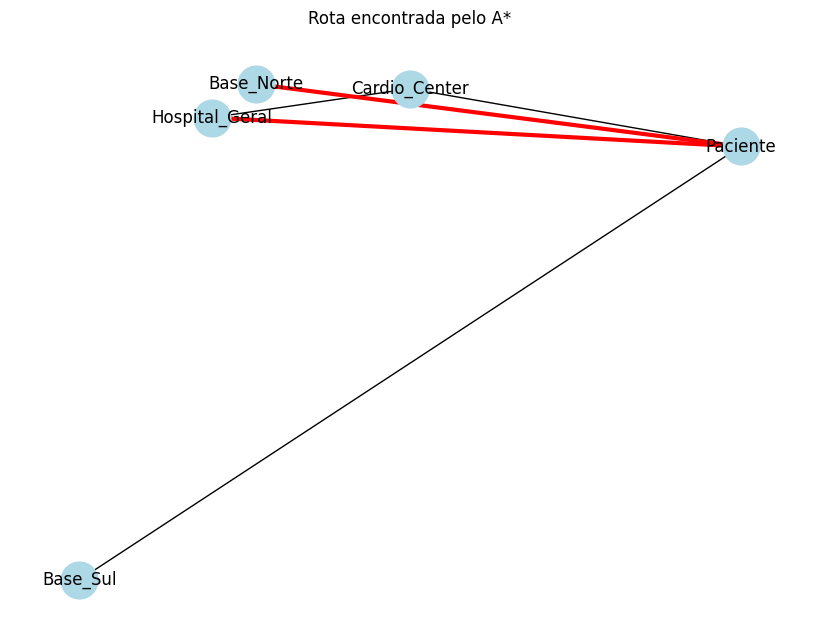

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

# Criar grafo
G_nx = nx.Graph()
for u in G:
    for v, cost in G[u].items():
        G_nx.add_edge(u, v, weight=cost)

# Layout aproximado pelas coordenadas
pos = {node: (lon, lat) for node, (lat, lon) in coords.items()}

# Desenhar grafo
plt.figure(figsize=(8,6))
nx.draw(G_nx, pos, with_labels=True, node_size=700, node_color="lightblue")

# Destacar rota A*
path, total, expanded = a_star_search("Base_Norte", "Hospital_Geral", coords, G)
edges_path = list(zip(path, path[1:]))
nx.draw_networkx_edges(G_nx, pos, edgelist=edges_path, edge_color="red", width=3)

plt.title("Rota encontrada pelo A*")
plt.show()
